In [1]:
import cv2
import json
import math
import os
import os.path
import re
import tempfile
import airsim
import numpy as np
from PIL import Image
from matplotlib import pyplot
import quickstart as util
import utils_KITTI as utilkitti

Using TensorFlow backend.
/home/islab/.local/share/virtualenvs/depth_prediction-uX_uZt9E/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/islab/.local/share/virtualenvs/depth_prediction-uX_uZt9E/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/islab/.local/share/virtualenvs/depth_prediction-uX_uZt9E/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) /

In [2]:
# 資料路徑
DATA_PATH = '/home/islab/Documents/drone/depth_prediction/data/random/data/2020-03-30-01-10/depth_planner/2020-03-30-01-19-14'
GREY_PIC_PATH = '/home/islab/Documents/drone/depth_prediction/result/vis_depth/2020-03-30-01-19-14/visualized_depth'
RESULT_PATH = '/home/islab/Documents/drone/depth_prediction/depth_differ/result/2020-03-30-01-19-14'

# Model Input 解析度設定
INPUT_HEIGHT = 320
INPUT_WIDTH = 384

#
ARROW_SIZE = 50

/home/islab/Documents/drone/depth_prediction/depth_differ/result/2020-03-30-01-19-14/3D_analysis/001.png
[0 0 0 0 0 0 0 0]
/home/islab/Documents/drone/depth_prediction/depth_differ/result/2020-03-30-01-19-14/3D_analysis/002.png
[0 0 0 0 0 0 0 0]
/home/islab/Documents/drone/depth_prediction/depth_differ/result/2020-03-30-01-19-14/3D_analysis/003.png
[0 0 0 0 0 0 0 0]
/home/islab/Documents/drone/depth_prediction/depth_differ/result/2020-03-30-01-19-14/3D_analysis/004.png
[0 0 0 0 0 0 0 0]
/home/islab/Documents/drone/depth_prediction/depth_differ/result/2020-03-30-01-19-14/3D_analysis/005.png
[0 0 0 0 0 0 0 0]
/home/islab/Documents/drone/depth_prediction/depth_differ/result/2020-03-30-01-19-14/3D_analysis/006.png
[0 0 0 0 0 0 0 0]
/home/islab/Documents/drone/depth_prediction/depth_differ/result/2020-03-30-01-19-14/3D_analysis/007.png
[0 0 0 0 0 0 0 0]
/home/islab/Documents/drone/depth_prediction/depth_differ/result/2020-03-30-01-19-14/3D_analysis/008.png
[0 0 0 0 0 0 0 0]
/home/islab/Docu

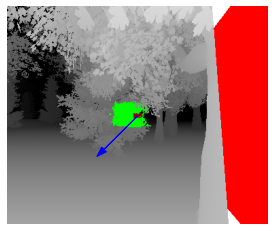

In [3]:
result_image_folder_path = os.path.join(RESULT_PATH, '3D_analysis')
if not os.path.exists(result_image_folder_path):
    os.makedirs(result_image_folder_path)
for i in range(50):
    # 讀取影像
    n = "%03d" % (i+1)
    depth, scale = utilkitti.read_pfm(os.path.join(DATA_PATH, str(n)+'.pfm'))
    X = np.zeros((INPUT_HEIGHT, INPUT_WIDTH))
    Y = np.zeros((INPUT_HEIGHT, INPUT_WIDTH))
    im = Image.open(os.path.join(GREY_PIC_PATH, str(n)+'.png'))
    im_rgb = im.convert("RGB")
    danger = False
    for j in range(INPUT_HEIGHT):
        for k in range(INPUT_WIDTH):
            Y[j, k] = depth[j, k] * (j - 160) / 192
            X[j, k] = depth[j, k] * (k - 192) / 192
            if abs(X[j, k]) <= 0.5 and abs(Y[j, k]) <= 0.25:
                if depth[j, k] > 10:
                    im_rgb.putpixel((k, j), (150, 0, 0))
                else:
                    im_rgb.putpixel((k, j), (256, 0, 0))
                    danger = True
    #
    counter = np.array([0, 0, 0, 0, 0, 0, 0, 0])
    if danger:
        for j in range(INPUT_HEIGHT):
            for k in range(INPUT_WIDTH):
                if depth[j, k] > 10:
                    if abs(X[j, k]) <= 2.5 and abs(Y[j, k]) <= 1.25 and (abs(X[j, k]) > 0.5 or abs(Y[j, k]) > 0.25):
                        im_rgb.putpixel((k, j), (0, 256, 0))
                        if X[j, k] < -0.5 and Y[j, k] > 0.25:
                            counter[0] += 1
                        elif abs(X[j, k]) <= 0.5 and Y[j, k] > 0.25:
                            counter[1] += 1
                        elif X[j, k] > 0.5 and Y[j, k] > 0.25:
                            counter[2] += 1
                        elif X[j, k] < -0.5 and abs(Y[j, k]) <= 0.25:
                            counter[3] += 1
                        elif X[j, k] > 0.5 and abs(Y[j, k]) <= 0.25:
                            counter[4] += 1
                        elif X[j, k] < -0.5 and Y[j, k] < -0.25:
                            counter[5] += 1
                        elif abs(X[j, k]) <= 0.5 and Y[j, k] < -0.25:
                            counter[6] += 1
                        else:
                            counter[7] += 1
    #
    pyplot.clf()
    pyplot.axis('off')
    pyplot.imshow(im_rgb)
    if danger:
        max_area = np.argmax(counter)
        if max_area == 0:
            pyplot.arrow(INPUT_WIDTH/2, INPUT_HEIGHT/2, -ARROW_SIZE, -ARROW_SIZE, color='b', head_width=10)
        elif max_area == 1:
            pyplot.arrow(INPUT_WIDTH/2, INPUT_HEIGHT/2, 0, -ARROW_SIZE, color='b', head_width=10)
        elif max_area == 2:
            pyplot.arrow(INPUT_WIDTH/2, INPUT_HEIGHT/2, ARROW_SIZE, -ARROW_SIZE, color='b', head_width=10)
        elif max_area == 3:
            pyplot.arrow(INPUT_WIDTH/2, INPUT_HEIGHT/2, -ARROW_SIZE, 0, color='b', head_width=10)
        elif max_area == 4:
            pyplot.arrow(INPUT_WIDTH/2, INPUT_HEIGHT/2, ARROW_SIZE, 0, color='b', head_width=10)
        elif max_area == 5:
            pyplot.arrow(INPUT_WIDTH/2, INPUT_HEIGHT/2, -ARROW_SIZE, ARROW_SIZE, color='b', head_width=10)
        elif max_area == 6:
            pyplot.arrow(INPUT_WIDTH/2, INPUT_HEIGHT/2, 0, ARROW_SIZE, color='b', head_width=10)
        elif max_area == 7:
            pyplot.arrow(INPUT_WIDTH/2, INPUT_HEIGHT/2, ARROW_SIZE, ARROW_SIZE, color='b', head_width=10)
    # 儲存結果
    pyplot.savefig(os.path.join(result_image_folder_path, str(n)+'.png'))
    print(os.path.join(result_image_folder_path, str(n)+'.png'))
    print(counter)